In [1]:
# import libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
# Display plots in line

In [2]:
#load data to variables
blobdata = np.load('backprop_blob.npz') #blob file
#print(list(blobdata))
blobtrain_x = blobdata['train_x']
blobtrain_y = blobdata['train_y']
blobtest_x = blobdata['test_x']
blobtest_y = blobdata['test_y']

ringdata = np.load('backprop_ring.npz') #ring file
#print(list(ringdata)) 
ringtrain_x = ringdata['train_x']
ringtrain_y = ringdata['train_y']
ringtest_x = ringdata['test_x']
ringtest_y = ringdata['test_y']

In [3]:
global num_hidden
global num_output 
global learn_rate
global num_input
global num_epochs 

In [4]:
#feed forward neural network function for a single sample
def feedForward(input_vect, w_output, w_hidden):
    
    h_vect = np.zeros(num_hidden) #vector to store hidden layer values
    
    for j in range(num_hidden):
        a = np.dot(input_vect, w_hidden[:,j]) #dot product between input and weights
        y = 1/(1+np.exp(-a)) #sigmoid function
        h_vect[j] = y #populate h_vect, hidden layer outputs
    a = np.dot(h_vect, w_output) #dot product between h and weights
    y_out = 1/(1+np.exp(a)) #sigmoid function, y is the output   

    return y_out, h_vect

In [5]:
def backProp(target_out, y_out, h_vect, w_output, w_hidden, input_vect):
    #First find the new output layer weights
    
    pd_Etot_Yout = y_out - target_out #partial derivative of E_total wrt the y output value
    pd_Yout_Netout = y_out*(1-y_out)#partial derivative of Y_out wrt net input is the pd of the sigmoid function, whch is f(x)(1-f(x))
    delta_out = pd_Etot_Yout*pd_Yout_Netout #This delta value is the same for all output weights since we have only one output node
    pd_Etot_Wout = np.asscalar(delta_out)*np.transpose(np.matrix(h_vect)) #This is a 10x1 vector, multiplying delta_out by the found h vector (hidden layer outputs)
    w_output_new = w_output + learn_rate*pd_Etot_Wout #update weight vector
    
    #Next, find the new hidden layer weights
    pd_Etot_H = np.asscalar(delta_out)*w_hidden #pd of total error wrt output of h1 (2x10), 1st row is 1st feature, 2nd row is 2nd feature
    pd_H_NetH = np.multiply(h_vect, (1-h_vect))#pd of H output wrt net H --derivative of sigmoid function is f(x)(1-f(x)). Element-wise multiplication (1x10)
    
    #get delta values for hidden layer
    delta_hid = np.zeros((num_input, num_hidden)) #initialize array for delta values
    for j in range(num_input):
        delta_hid[j,:] = (np.multiply(w_hidden[j,:], pd_H_NetH))
    #Multiply the hidden delta values by the input vector to get pf of Etot wrt hidden weights
    pd_NetH_Whid = np.transpose(np.matrix(input_vect)) #pd of Net H wrt. hidden weights is just the input: 2x1 vector
    pd_Etot_Whid = np.matrix(np.zeros((num_input, num_hidden)))
    for k in range(num_hidden):
        pd_Etot_Whid[:,k] = np.multiply((np.matrix(delta_hid))[:,k], pd_NetH_Whid) 
    w_hidden_new = w_hidden + learn_rate*pd_Etot_Whid #Update hidden weights
    
    return w_output_new, w_hidden_new
    

In [6]:
def RMS(y_vect, target_out, num_samples):
    error = y_vect - target_out
    square_error = np.multiply(error, error) #square each term
    RMS = np.sum(square_error)/num_samples
    return RMS

In [7]:
def findDecisionBound(x0_vect, x1_vect, w_output, w_hidden):
    size_x0 = x0_vect.size
    size_x1 = x1_vect.size
    y_array = np.array(np.zeros((size_x1, size_x0)))
    for i in range(size_x0):
        for j in range(size_x1):
            input_vect = [x0_vect[i], x1_vect[j]]
            y_out, h_vect = feedForward(input_vect, w_output, w_hidden)
            y_array[j,i] = int(round(np.asscalar(y_out)))
    return y_array

In [8]:
def process_data(datatrain_x, datatest_x, datatrain_y, datatest_y, w_output, w_hidden):
    num_samples = (datatrain_x.shape)[0] 
    num_samplesTest = (datatest_x.shape)[0]
    y_vect = np.zeros(num_samples)
    y_vectTest = np.zeros(num_samplesTest)
    train_error = np.zeros(num_epochs + 1) #Add one more for epoch 0 (initial error)
    test_error = np.zeros(num_epochs + 1)
    
    for k in range(num_epochs + 1): #iterate through epochs
        for j in range(num_samplesTest): #This is just iterating through test data to get the y vector for test data
            input_vect = datatest_x[j,:] #Note that the first index is the initial error after epoch 0.
            y_out, h_vect = feedForward(input_vect, w_output, w_hidden)
            y_vectTest[j] = y_out

        for i in range(num_samples): #iterate through each sample
            input_vect = datatrain_x[i,:] #1x2 sample vector
            y_out, h_vect = feedForward(input_vect, w_output, w_hidden) #feedforwards, y_out is the output layer value, and h_vect are the outputs of the hidden layer
            y_vect[i] = y_out

            target_out = datatrain_y[i]
            w_output, w_hidden = backProp(target_out, y_out, h_vect, w_output, w_hidden, input_vect) #update output weights and hidden weights

        #Get training error and Test error (RMS)
        train_error[k] = RMS(y_vect, datatrain_y, num_samples)
        test_error[k] = RMS(y_vectTest, datatest_y, num_samplesTest)

    return train_error, test_error, y_vect, y_vectTest, w_output, w_hidden

In [9]:
def plotRMS (epochs, train_RMSerror, test_RMSerror, datatitle):
    epoch_vect = np.linspace(0, num_epochs, num_epochs+1)
    plt.scatter(epoch_vect, train_RMSerror, c='r')
    plt.scatter(epoch_vect, test_RMSerror, c='b')
    plt.title(datatitle + ' Training RMS error (red) vs. Test RMS error (blue)')
    plt.xlabel('epoch number')
    plt.ylabel('RMS error')
    plt.show()


In [10]:
def plotData (datatrain_x, datatest_x, datatrain_y, datatest_y, dataTitle, dataType):
    num_samples = (datatrain_x.shape)[0] 
    num_samplesTest = (datatest_x.shape)[0]
    
    for i in range(num_samples):
        if int(round(datatrain_y[i])) == 0:
            plt.scatter(datatrain_x[i,0], datatrain_x[i,1], c = 'b')
        else: 
            plt.scatter(datatrain_x[i,0], datatrain_x[i,1], c = 'r')
    for i in range(num_samplesTest):
        if int(round(datatest_y[i])) == 0:
            plt.scatter(datatest_x[i,0], datatest_x[i,1], c = 'c')
        else:
            plt.scatter(datatest_x[i,0], datatest_x[i,1], c = 'm')
        
    plt.title(dataTitle + ', ' + dataType + ': Train Class 0 (blue) vs. Class 1 (red), \nTest Class 0 (cyan) vs. Class 1 (magenta)')
    plt.xlabel('x0')
    plt.ylabel('x1')


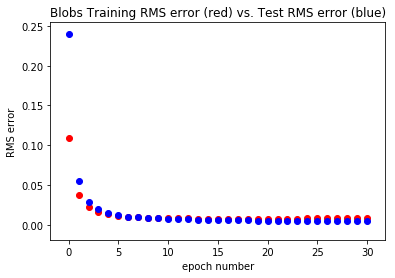

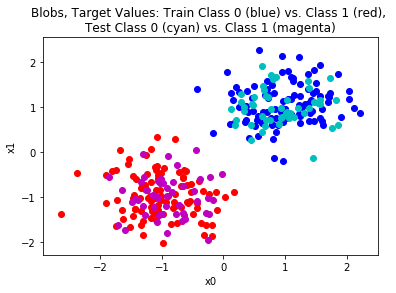

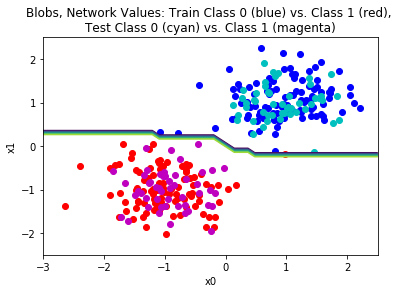

In [11]:
######For Blob Data######
dataTitle = 'Blobs'

num_hidden = 10 #one hidden layer of 10 sigmoid units 
num_output = 1 # one output unit (sigmoid)
learn_rate = 0.1
num_epochs = 30
num_input = (blobtrain_x.shape)[1] #Number of features, columns in training x

#Initialize weights randomly between a range
w_hidden =  np.random.uniform(low=-3, high=3, size=(num_input, num_hidden)) #2x10 matrix
w_output =  np.random.uniform(low=-0.1, high=0.1, size=(num_hidden, num_output)) #10x1 matrix
train_RMSerror, test_RMSerror, y_vect, y_vectTest, w_output, w_hidden = process_data(blobtrain_x, blobtest_x, blobtrain_y, blobtest_y, w_output, w_hidden)

#Get decision boundary
x0_vect = np.linspace(-3,2.5,50)
x1_vect = np.linspace(-2.5,2.5,50)
y_array = findDecisionBound(x0_vect, x1_vect, w_output, w_hidden)

#Plot RMS
plt.figure(1)
plotRMS(num_epochs, train_RMSerror, test_RMSerror, dataTitle)

#Plot Target Values
plt.figure(2)
dataType = 'Target Values'
plotData(blobtrain_x, blobtest_x, blobtrain_y, blobtest_y, dataTitle, dataType)

#Plot Values obtained from the Network
plt.figure(3)
dataType = 'Network Values'
plotData(blobtrain_x, blobtest_x, y_vect, y_vectTest, dataTitle, dataType)
plt.contour(x0_vect, x1_vect, y_array)

Text(0.5, 1.0, 'Blobs Blue = Class 0, Red = Class 1')

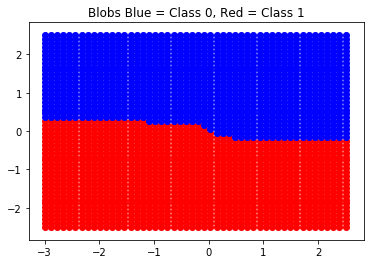

In [12]:
plt.figure(4)
size_x0 = x0_vect.size
size_x1 = x1_vect.size
for i in range(size_x0):
    for j in range(size_x1):
        if y_array[j,i] == 0:
            plt.scatter(x0_vect[i], x1_vect[j], c = 'b')    
        elif y_array[j,i] == 1:
            plt.scatter(x0_vect[i], x1_vect[j], c = 'r') 
#Aside, coloured decision Boundary
plt.title('Blobs Blue = Class 0, Red = Class 1')
            

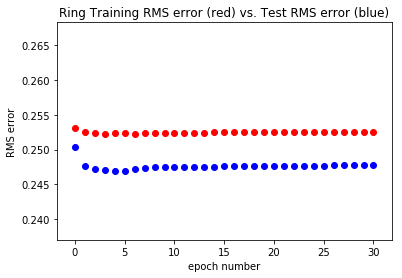

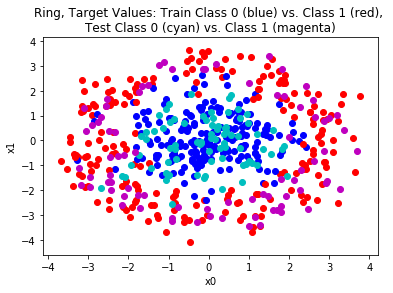

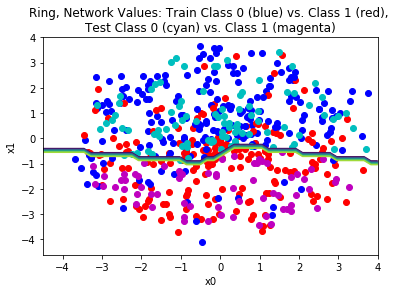

In [15]:
######For Ring Data######
dataTitle = 'Ring'

num_hidden = 10 #one hidden layer of 10 sigmoid units 
num_output = 1 # one output unit (sigmoid)
learn_rate = 0.1
num_epochs = 30
num_input = (ringtrain_x.shape)[1] #Number of features, columns in training x

#Initialize weights randomly between a range
w_hidden =  np.random.uniform(low=-3, high=3, size=(num_input, num_hidden)) #2x10 matrix
w_output =  np.random.uniform(low=-0.1, high=0.1, size=(num_hidden, num_output)) #10x1 matrix
train_RMSerror, test_RMSerror, y_vect, y_vectTest, w_output, w_hidden = process_data(ringtrain_x, ringtest_x, ringtrain_y, ringtest_y, w_output, w_hidden)

#Get decision boundary
x0_vect = np.linspace(-4.5,4,50)
x1_vect = np.linspace(-4,4,50)
y_array = findDecisionBound(x0_vect, x1_vect, w_output, w_hidden)

#Plot RMS
plt.figure(1)
plotRMS(num_epochs, train_RMSerror, test_RMSerror, dataTitle)

#Plot Target Values
plt.figure(2)
dataType = 'Target Values'
plotData(ringtrain_x, ringtest_x, ringtrain_y, ringtest_y, dataTitle, dataType)

#Plot Values obtained from the Network
plt.figure(3)
dataType = 'Network Values'
plotData(ringtrain_x, ringtest_x, y_vect, y_vectTest, dataTitle, dataType)
plt.contour(x0_vect, x1_vect, y_array)



Text(0.5, 1.0, 'Rings Blue = Class 0, Red = Class 1')

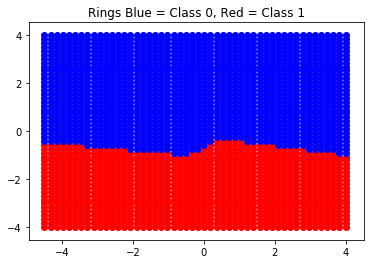

In [16]:
plt.figure(4)
size_x0 = x0_vect.size
size_x1 = x1_vect.size
for i in range(size_x0):
    for j in range(size_x1):
        if y_array[j,i] == 0:
            plt.scatter(x0_vect[i], x1_vect[j], c = 'b')    
        elif y_array[j,i] == 1:
            plt.scatter(x0_vect[i], x1_vect[j], c = 'r') 
#Aside, coloured decision Boundary
plt.title('Rings Blue = Class 0, Red = Class 1')